# Accessing Ivy Glioblastoma Atlas Project data

## Introduction

The Ivy Glioblastoma Atlas Project is a collection of data from glioblastoma brain tumors. The project is a collaboration between the Allen Institute for Brain Science and the Ben and Catherine Ivy Foundation. Glioblastoma is an aggressive brain cancer. Survival after diagnosis is just 12 to 15 months. An interactive atlas is available at https://glioblastoma.alleninstitute.org/ and consists of:

- Images of in situ hybridization experiments identifying where key genes are expressed in the tumor tissue (20x magnification)
- Matching histology images using Hematoxylin and Eosin (H&E) stain
- Gene expression masks for all ISH images
- Annotated mask images of tumor structures for all ISH and H&E images

The project also comprises additional data modalities that are not currently available from the AWS bucket. These are:

- RNA sequencing data for 270 samples from 44 tumors
- Companion clinical database hosted at https://ivygap.org/ (registration required)
- Accompanying MRI/CT scan data for the patients is available at [The Cancer Imaging Archive](https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=22515597).

The project has been published in the [May 11, 2018 edition of Science](https://science.sciencemag.org/content/360/6389/660).

## Accessing Ivy Glioblastoma Atlas Project data with AWS S3

The image data for the project is being made available as an Amazon Web Services (AWS) public dataset to enable computational scientists easy access to a rich, well-annotated data set for training and validation of machine learning, classification, and developing computer vision applications such as image segmentation. The data are free and publicly available from the AWS Simple Storage Service (S3) s3://allen-ivy-glioblastoma-atlas/ and/or https://console.aws.amazon.com/s3/buckets/allen-ivy-glioblastoma-atlas (needs at least an AWS free account to view).

The root of the S3 bucket contains 3 metadata \*.json files (`donor_metadata.json`, `specimen_metadata.json`, and `section_metadata.json`) that can be used to explore the dataset and determine download links. 

The relationship between donors, specimens, and sections is as follows:
- Each donor can have one or more (tumor tissue) specimens
- Each (tumor tissue) specimen can be sliced into multiple sections
- Each section can have multiple sub-images that show histology, gene expression, annotated masks, etc...

The dataset is comprised of 42 donors, 946 tumor specimens, 20470 sliced tissue sections, and a total of 135138 microscopy/expression/annotation images. The total size of this dataset is ~8.5 Terabytes. The following sections will show some examples of how to obtain and interact with metadata as well as microscopy image data.

## Exploring donor metadata

Let's start by looking at the donors for the dataset. Before that, we need to set up a client that will access the AWS S3 dataset.

In [1]:
from open_dataset_tools.aws_utils import get_public_boto3_client


# Set up a boto3 client that can access public S3 data without needing AWS credentials
s3_client = get_public_boto3_client()

# If you have already set up and would like to use AWS credentials you could do:
#
# import boto3
# s3_client = boto3.client('s3')

Let's also import some useful utility functions:

In [2]:
from open_dataset_tools.ivy_gap_utils import get_donor_metadata, get_specimen_metadata, get_section_metadata

In [3]:
donor_metadata = get_donor_metadata(s3_client)

In [4]:
donor_metadata.head()

,age_in_years,donor_id,donor_name,egfr_amplification,extent_of_resection,external_donor_name,initial_kps,mgmt_methylation,molecular_subtypes,surgery,survival_days
0,66,10865,H366-0012b,Yes,Complete,W1-1-2,100,No,[Classical],primary,105.0
1,64,10926,H366-0013,Yes,Complete,W2-1-1,90,Yes,"[Classical, Neural]",primary,1096.0
2,59,113597455,H366-0049,None,Complete,W42-1-1,70,Yes,"[Neural, Proneural]",primary,197.0
3,61,113597961,H366-0050,None,Complete,W43-1-1,90,No,"[Mesenchymal, Neural]",primary,300.0
4,65,12102,H366-0018,Yes,Complete,W3-1-1,100,No,"[Classical, Mesenchymal]",primary,982.0


The donor metadata table contains metadata pertaining to donors of glioblastoma specimens in the data. For detailed descriptions of the column names please refer to the `CLINICAL DATA CATEGORIES` section on page 11 of the `Overview` PDF found in the [Ivy GAP documentation page](https://help.brain-map.org/display/glioblastoma/Documentation).


For now, let's see how many donors there are in the dataset:

In [5]:
print(f"There are {len(donor_metadata)} donors in the Ivy GAP dataset")

There are 42 donors in the Ivy GAP dataset


When analyzing data, we may want to limit our analysis to donors with certain conditions. Let's try finding donors who had no evidence of disease as indicated by initial Karnofsky Performance Status (KPS).

In [6]:
donor_kps_filter = donor_metadata["initial_kps"] == 100
donor_metadata[donor_kps_filter]

,age_in_years,donor_id,donor_name,egfr_amplification,extent_of_resection,external_donor_name,initial_kps,mgmt_methylation,molecular_subtypes,surgery,survival_days
0,66,10865,H366-0012b,Yes,Complete,W1-1-2,100,No,[Classical],primary,105.0
4,65,12102,H366-0018,Yes,Complete,W3-1-1,100,No,"[Classical, Mesenchymal]",primary,982.0
5,60,12105,H366-0022,No,Sub-total,W7-1-1,100,Yes,[Mesenchymal],primary,437.0
11,44,12111,H366-0025,No,Complete,W10-1-1,100,Yes,[Proneural],primary,NaN
12,57,12112,H366-0026,No,Complete,W11-1-1,100,Yes,"[Classical, Mesenchymal]",primary,1076.0
16,76,12996,H366-0033,Yes,Complete,W16-1-1,100,No,"[Neural, Proneural]",primary,353.0
18,57,13988,H366-0036,None,Complete,W26-1-1,100,Yes,[Neural],primary,1293.0
19,68,14220,H366-0037,None,Sub-total,W28-1-1,100,No,"[Mesenchymal, Neural]",primary,300.0
20,73,14221,H366-0038,Yes,Complete,W29-1-1,100,No,"[Classical, Neural]",primary,260.0
29,64,15400,H366-0047,Yes,Complete,W40-1-1,100,No,[Neural],primary,184.0


One might want to filter on multiple conditions such as donors with minimal evidence of disease (KPS >= 90) and who had tumors where the O-6-methylguanine-DNA methyltransferase DNA repair gene was methylated.

In [7]:
donor_compound_filter = (donor_metadata["initial_kps"] >= 90) & (donor_metadata["mgmt_methylation"] == "Yes")
donor_metadata[donor_compound_filter]

,age_in_years,donor_id,donor_name,egfr_amplification,extent_of_resection,external_donor_name,initial_kps,mgmt_methylation,molecular_subtypes,surgery,survival_days
1,64,10926,H366-0013,Yes,Complete,W2-1-1,90,Yes,"[Classical, Neural]",primary,1096.0
5,60,12105,H366-0022,No,Sub-total,W7-1-1,100,Yes,[Mesenchymal],primary,437.0
11,44,12111,H366-0025,No,Complete,W10-1-1,100,Yes,[Proneural],primary,NaN
12,57,12112,H366-0026,No,Complete,W11-1-1,100,Yes,"[Classical, Mesenchymal]",primary,1076.0
17,52,12997,H366-0035,Yes,Complete,W22-1-1,90,Yes,"[Classical, Neural]",primary,NaN
18,57,13988,H366-0036,None,Complete,W26-1-1,100,Yes,[Neural],primary,1293.0
23,56,14737,H366-0041,No,Complete,W32-1-1,90,Yes,[Proneural],primary,NaN
31,36,159992499,H366-0053,No,Sub-total,W18-1-1,90,Yes,[],primary,903.0
34,26,180682564,H366-0059,None,Complete,W50-1-1,90,Yes,[],primary,NaN
35,54,268091642,H366-0061,None,Complete,W53-1-1,90,Yes,[Classical],primary,NaN


If we just want the donor ids for our previous query we can just do:

In [8]:
donor_metadata[donor_compound_filter]['donor_id'].values

array([    10926,     12105,     12111,     12112,     12997,     13988,
           14737, 159992499, 180682564, 268091642, 292023102, 292023109])

## Exploring specimen metadata

The specimen metadata table describes tumor specimens and information about the donor source, study, as well as a specimen page link where more information about the specimen can be obtained.

For now, let's take a look at how many specimens exist in the dataset.

In [9]:
specimen_metadata = get_specimen_metadata(s3_client)
specimen_metadata.head()

,donor_id,donor_name,external_donor_name,specimen_id,specimen_name,specimen_page_link,study_name
0,10865,H366-0012b,W1-1-2,264712561,W1-1-2-AB.2.01,http://glioblastoma.alleninstitute.org/ish/spe...,Cancer Stem Cells ISH Survey
1,10865,H366-0012b,W1-1-2,264712748,W1-1-2-AB.2.02,http://glioblastoma.alleninstitute.org/ish/spe...,Cancer Stem Cells ISH Survey
2,10865,H366-0012b,W1-1-2,264712751,W1-1-2-AB.2.03,http://glioblastoma.alleninstitute.org/ish/spe...,Cancer Stem Cells ISH Survey
3,10865,H366-0012b,W1-1-2,264713700,W1-1-2-K.2.01,http://glioblastoma.alleninstitute.org/ish/spe...,Cancer Stem Cells ISH Survey
4,10865,H366-0012b,W1-1-2,264713760,W1-1-2-K.2.02,http://glioblastoma.alleninstitute.org/ish/spe...,Cancer Stem Cells ISH Survey


In [10]:
print(f"There are {len(specimen_metadata)} tumor specimens in the Ivy GAP dataset")

There are 946 tumor specimens in the Ivy GAP dataset


Let's take a look at the studies associated with all the specimens:

In [11]:
specimen_metadata["study_name"].unique()

array(['Cancer Stem Cells ISH Survey', 'Anatomic Structures RNA Seq',
       'Cancer Stem Cells RNA Seq',
       'Anatomic Structures ISH for Enriched Genes',
       'Cancer Stem Cells ISH for Enriched Genes',
       'Anatomic Structures ISH Survey'], dtype=object)

If we are interested in specimens from a specific study, for example, the "Anatomic Structures ISH Survey" we can filter the table like so:

In [12]:
specimen_study_filter = specimen_metadata["study_name"] == "Anatomic Structures ISH Survey"
specimen_metadata[specimen_study_filter]

,donor_id,donor_name,external_donor_name,specimen_id,specimen_name,specimen_page_link,study_name
32,10865,H366-0012b,W1-1-2,706600,W1-1-2-K.1.01,http://glioblastoma.alleninstitute.org/ish/spe...,Anatomic Structures ISH Survey
33,10865,H366-0012b,W1-1-2,706601,W1-1-2-K.1.02,http://glioblastoma.alleninstitute.org/ish/spe...,Anatomic Structures ISH Survey
34,10865,H366-0012b,W1-1-2,706602,W1-1-2-K.1.03,http://glioblastoma.alleninstitute.org/ish/spe...,Anatomic Structures ISH Survey
35,10865,H366-0012b,W1-1-2,706603,W1-1-2-K.1.04,http://glioblastoma.alleninstitute.org/ish/spe...,Anatomic Structures ISH Survey
36,10865,H366-0012b,W1-1-2,706604,W1-1-2-K.1.05,http://glioblastoma.alleninstitute.org/ish/spe...,Anatomic Structures ISH Survey
...,...,...,...,...,...,...,...
418,12165,H366-0029,W12-1-1,706864,W12-1-1-D.2.02,http://glioblastoma.alleninstitute.org/ish/spe...,Anatomic Structures ISH Survey
422,12165,H366-0029,W12-1-1,706873,W12-1-1-E.1.01,http://glioblastoma.alleninstitute.org/ish/spe...,Anatomic Structures ISH Survey
423,12165,H366-0029,W12-1-1,706874,W12-1-1-E.1.02,http://glioblastoma.alleninstitute.org/ish/spe...,Anatomic Structures ISH Survey
424,12165,H366-0029,W12-1-1,706875,W12-1-1-E.1.03,http://glioblastoma.alleninstitute.org/ish/spe...,Anatomic Structures ISH Survey


There may be analyses where one only wants to look at specimens from donors with certain criteria. Here is an example of finding specimens from the "Cancer Stem Cells ISH for Enriched Genes" study from donors with low initial KPS values:

In [13]:
donor_kps_filter = donor_metadata["initial_kps"] < 70
selected_donor_ids = donor_metadata[donor_kps_filter]["donor_id"].values

specimen_study_and_donor_kps_filter = (
    (specimen_metadata["study_name"] == "Cancer Stem Cells ISH Survey")
    & (specimen_metadata["donor_id"].isin(selected_donor_ids))
)
specimen_metadata[specimen_study_and_donor_kps_filter]

,donor_id,donor_name,external_donor_name,specimen_id,specimen_name,specimen_page_link,study_name
728,15350,H366-0046,W39-1-1,293591387,W39-1-1-O.01,http://glioblastoma.alleninstitute.org/ish/spe...,Cancer Stem Cells ISH Survey
729,15350,H366-0046,W39-1-1,293591503,W39-1-1-O.02,http://glioblastoma.alleninstitute.org/ish/spe...,Cancer Stem Cells ISH Survey


## Exploring section metadata and interacting with images

The section metadata table includes information about sliced tissues sections obtained from specimens including primer sequence data used for in situ hybridization experiments.

As before, let's take a look at how many tissues sections there are in the dataset.

NOTE: The section metadata table is ~56 MB, so may take a little time to download and load.

In [14]:
section_metadata = get_section_metadata(s3_client)
section_metadata.head()

,donor_id,entrez_id,forward_primer_sequence_data,forward_sequence_length,gene_acronym,gi,ncbi_accession_number,orientation,predicted_sequence_data,predicted_sequence_length,reverse_primer_sequence_data,reverse_sequence_length,section_data_set_id,section_thickness,specimen_id,sub_images,treatment
0,10865,2064.0,CAGTTACCAGTGCCAATATCCA,22.0,ERBB2,51480411.0,BC080193.1,Antisense,CAGTTACCAGTGCCAATATCCAGGAGTTTGCTGGCTGCAAGAAGAT...,974.0,ATCGTGTACTTCCGGATCTTCT,22.0,265850294,20,264712561,"[{'bits_per_component': 8, 'sub_image_id': 265...",ISH
1,10865,2034.0,CACATCTTTGGATAACGACCTG,22.0,EPAS1,262527236.0,NM_001430.4,Antisense,CACATCTTTGGATAACGACCTGAAGATTGAAGTGATTGAGAAGCTC...,931.0,GAACCTGCTCTTGCTGTTCTC,21.0,265850345,20,264712561,"[{'bits_per_component': 8, 'sub_image_id': 265...",ISH
2,10865,1749.0,AAAGCTCTCAACCCCTACCAGT,22.0,DLX5,84043959.0,NM_005221.5,Antisense,AAAGCTCTCAACCCCTACCAGTATCAGTATCACGGCGTGAACGGCT...,767.0,AGTTTTCCGAACTTCCCCATA,21.0,265850396,20,264712561,"[{'bits_per_component': 8, 'sub_image_id': 265...",ISH
3,10865,57291.0,CTCTTTGTCAGCTGGAGTTGC,21.0,DANCR,194394211.0,NR_024031.1,Antisense,CTCTTTGTCAGCTGGAGTTGCGCGGGCTGACGCGCCACTATGTAGC...,512.0,ATAGCGCCTAGATAACGGTTCA,22.0,265850447,20,264712561,"[{'bits_per_component': 8, 'sub_image_id': 265...",ISH
4,10865,1490.0,CTTACCGACTGGAAGACACGTT,22.0,CTGF,98986335.0,NM_001901.2,Antisense,CTTACCGACTGGAAGACACGTTTGGCCCAGACCCAACTATGATTAG...,953.0,CTTGACTCAGTCTCTTGATGGCT,23.0,265850498,20,264712561,"[{'bits_per_component': 8, 'sub_image_id': 265...",ISH


In [15]:
print(f"There are {len(section_metadata)} sections in the Ivy GAP dataset")

There are 20470 sections in the Ivy GAP dataset


Let's take a look at the section metadata for one of the two specimens we found in the previous Exploring specimen metadata section:

In [16]:
specimens_of_interest = specimen_metadata[specimen_study_and_donor_kps_filter]["specimen_id"].values
section_specimen_filter = section_metadata["specimen_id"].isin(specimens_of_interest)
section_metadata[section_specimen_filter]

,donor_id,entrez_id,forward_primer_sequence_data,forward_sequence_length,gene_acronym,gi,ncbi_accession_number,orientation,predicted_sequence_data,predicted_sequence_length,reverse_primer_sequence_data,reverse_sequence_length,section_data_set_id,section_thickness,specimen_id,sub_images,treatment
15882,15350,3485.0,GATGACCACTCAGAAGGAGGC,21.0,IGFBP2,10835156.0,NM_000597.1,Antisense,GATGACCACTCAGAAGGAGGCCTGGTGGAGAACCACGTGGACAGCA...,642.0,CGTGTGTCAGAACTGGAAAATC,22.0,294215254,20,293591387,"[{'bits_per_component': 8, 'sub_image_id': 294...",ISH
15883,15350,960.0,AAATGGTCGCTACAGCATCTCT,22.0,CD44,48255936.0,NM_001001389.1,Antisense,AAATGGTCGCTACAGCATCTCTCGGACGGAGGCCGCTGACCTCTGC...,907.0,GCTTGTAGAATGTGGGGTCTCT,22.0,294215306,20,293591387,"[{'bits_per_component': 8, 'sub_image_id': 294...",ISH
15884,15350,4843.0,GACCACATCTACCAGGAGGAGA,22.0,NOS2,24041028.0,NM_000625.3,Antisense,GACCACATCTACCAGGAGGAGATGCTGGAGATGGCCCAGAAGGGGG...,807.0,GAATCATACAGGGAAGACCCAA,22.0,294215359,20,293591387,"[{'bits_per_component': 8, 'sub_image_id': 294...",ISH
15885,15350,57291.0,CTCTTTGTCAGCTGGAGTTGC,21.0,DANCR,194394211.0,NR_024031.1,Antisense,CTCTTTGTCAGCTGGAGTTGCGCGGGCTGACGCGCCACTATGTAGC...,512.0,ATAGCGCCTAGATAACGGTTCA,22.0,294215412,20,293591387,"[{'bits_per_component': 8, 'sub_image_id': 294...",ISH
15886,15350,2146.0,TAAAGAACTCACCGAACAGCAG,22.0,EZH2,322506096.0,NM_001203247.1,Antisense,TAAAGAACTCACCGAACAGCAGCTCCCAGGCGCACTTCCTCCTGAA...,938.0,AGCGGTTTTGACACTCTGAACT,22.0,294215463,20,293591387,"[{'bits_per_component': 8, 'sub_image_id': 294...",ISH
15887,15350,8842.0,CTGGGGCTGCTGTTTATTATTC,22.0,PROM1,224994187.0,NM_006017.2,Antisense,CTGGGGCTGCTGTTTATTATTCTGATGCCTCTGGTGGGGTATTTCT...,813.0,GACCCTTTTGATACCTGCTACG,22.0,294215514,20,293591387,"[{'bits_per_component': 8, 'sub_image_id': 294...",ISH
15888,15350,10631.0,AGAATACACTTTGCTGGCACCT,22.0,POSTN,209863033.0,NM_001135936.1,Antisense,AGAATACACTTTGCTGGCACCTGTGAATAATGCATTTTCTGATGAT...,804.0,TAGACAGTCACGGGGATTTCTT,22.0,294215565,20,293591387,"[{'bits_per_component': 8, 'sub_image_id': 294...",ISH
15889,15350,5156.0,CCGTGCTAAGGAAGAAGACAGT,22.0,PDGFRA,61699224.0,NM_006206.3,Antisense,CCGTGCTAAGGAAGAAGACAGTGGCCATTATACTATTGTAGCTCAA...,975.0,GATATCCAGCTCTTTCTTTGGC,22.0,294215618,20,293591387,"[{'bits_per_component': 8, 'sub_image_id': 294...",ISH
15890,15350,3397.0,AGCACGTCATCGACTACATCAG,22.0,ID1,341865545.0,NM_181353.2,Antisense,AGCACGTCATCGACTACATCAGGGACCTTCAGTTGGAGCTGAACTC...,806.0,AAACAGCCCCACAGAACTATTG,22.0,294215669,20,293591387,"[{'bits_per_component': 8, 'sub_image_id': 294...",ISH
15891,15350,10215.0,CTCACTAGAACTCATCCGACCC,22.0,OLIG2,17978474.0,NM_005806.1,Antisense,CTCACTAGAACTCATCCGACCCCCGACCACCACCTCCGGGAAAAGA...,749.0,GTGAGCAAACAGCTTAGCATTG,22.0,294215720,20,293591387,"[{'bits_per_component': 8, 'sub_image_id': 294...",ISH


Let's take a look at the histology images for the two specimens:

In [17]:
histology_filter = section_metadata["treatment"] == "H&E"
histology_sections = section_metadata[section_specimen_filter & histology_filter].dropna(axis=1, how='all')
histology_sections

,donor_id,section_data_set_id,section_thickness,specimen_id,sub_images,treatment
15898,15350,294218209,20,293591387,"[{'bits_per_component': 8, 'sub_image_id': 294...",H&E
15904,15350,294217897,20,293591503,"[{'bits_per_component': 8, 'sub_image_id': 294...",H&E


Now that we've narrowed down the number of sections that we are interested in, we can use the following `section_image_loader` utility to download and view the images:

In [18]:
from open_dataset_tools.ivy_gap_utils import section_image_loader

The `section_image_loader` expects at minimum, a section metadata table (can be filtered or unfiltered), and a `section_data_set_id` (whose value must exist in the section metadata table if it has been filtered) which can be obtained from the section metadata table.

Let's say we are interested in the images where `section_data_set_id == 294218209`.

NOTE: Set `verbose=True` to get a feel for what is being downloaded at any given time.

In [19]:
section_image_table = section_image_loader(
    section_meta_table=histology_sections,
    section_data_set_id=294218209,
    verbose=True
)

In [20]:
section_image_table.head()

,bits_per_component,sub_image_id,resolution,section_number,width,height,primary,annotation,boundary
0,8,294218391,0.4945,2,15040,18080,<open_dataset_tools.ivy_gap_utils.ImagePromise...,<open_dataset_tools.ivy_gap_utils.ImagePromise...,<open_dataset_tools.ivy_gap_utils.ImagePromise...
1,8,294218373,0.4945,5,15040,18080,<open_dataset_tools.ivy_gap_utils.ImagePromise...,<open_dataset_tools.ivy_gap_utils.ImagePromise...,<open_dataset_tools.ivy_gap_utils.ImagePromise...
2,8,294218355,0.4945,8,15040,18080,<open_dataset_tools.ivy_gap_utils.ImagePromise...,<open_dataset_tools.ivy_gap_utils.ImagePromise...,<open_dataset_tools.ivy_gap_utils.ImagePromise...
3,8,294218337,0.4945,11,15040,18080,<open_dataset_tools.ivy_gap_utils.ImagePromise...,<open_dataset_tools.ivy_gap_utils.ImagePromise...,<open_dataset_tools.ivy_gap_utils.ImagePromise...
4,8,294218319,0.4945,14,15040,18080,<open_dataset_tools.ivy_gap_utils.ImagePromise...,<open_dataset_tools.ivy_gap_utils.ImagePromise...,<open_dataset_tools.ivy_gap_utils.ImagePromise...


The section image table contains data as well as metadata for sub-images within a section. Images are loaded in as instances of a custom `ImagePromise` class. When the `.load()` method is called on an `ImagePromise` class, image data is downloaded from S3 and a Python Image Library (PIL) `Image` class is returned. For more details about the `Image` class, please see: https://pillow.readthedocs.io/en/stable/reference/Image.html

Let's take a look at the `ImagePromise` class returned by looking at the first row of the section_image_table:

In [21]:
print(f"Accessing the 0-th row of the 'primary' column of the section_image_table gives:\n{type(section_image_table['primary'][0])}\n")

image_promise = section_image_table["primary"][0]
# Note how downloading only happens when you call `load()` on the ImagePromise object
print(f"\nAfter calling 'load()' on an 'ImagePromise', what is returned is:\n{type(image_promise.load())}")

Accessing the 0-th row of the 'primary' column of the section_image_table gives:
<class 'open_dataset_tools.ivy_gap_utils.ImagePromise'>


After calling 'load()' on an 'ImagePromise', what is returned is:
<class 'PIL.JpegImagePlugin.JpegImageFile'>


Now, lets try viewing some of the images described in the section_image_table using matplotlib:

(-0.5, 15039.5, 18079.5, -0.5)

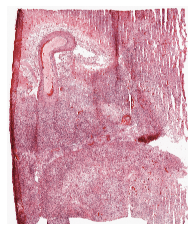

In [22]:
import matplotlib.pyplot as plt

# This line sets matplotlib to plot inline in the notebook
%matplotlib inline

# Notice that we can just index into the `section_image_table` and call '.load()' directly
# without needing to set an image_promise variable
plt.imshow(section_image_table["primary"][0].load())
plt.axis('off')

(-0.5, 15039.5, 18079.5, -0.5)

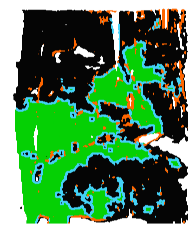

In [23]:
plt.imshow(section_image_table["annotation"][0].load())
plt.axis('off')

(-0.5, 15039.5, 18079.5, -0.5)

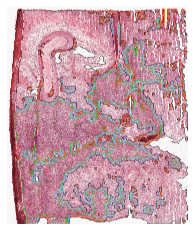

In [24]:
plt.imshow(section_image_table["boundary"][0].load())
plt.axis('off')

Looking at the specimen metadata table which these images are from, we can see that we have successfully programatically accessed a subset of the images shown on the website link:

In [25]:
reverse_lookup = specimen_metadata[specimen_metadata["specimen_id"] == histology_sections["specimen_id"].iloc[0]]
reverse_lookup

,donor_id,donor_name,external_donor_name,specimen_id,specimen_name,specimen_page_link,study_name
728,15350,H366-0046,W39-1-1,293591387,W39-1-1-O.01,http://glioblastoma.alleninstitute.org/ish/spe...,Cancer Stem Cells ISH Survey


In [26]:
reverse_lookup["specimen_page_link"].iloc[0]

'http://glioblastoma.alleninstitute.org/ish/specimen/show/293591387'

Another common set of analyses to perform with this dataset is to look at in situ hybridization (ISH) to localize genes of interest to a location in tissue. Here is an example for viewing ISH images for the gene `NOS2`:

In [27]:
ish_gene_filter = section_metadata["gene_acronym"] == "NOS2"
nos2_sections = section_metadata[section_specimen_filter & ish_gene_filter]
nos2_sections

,donor_id,entrez_id,forward_primer_sequence_data,forward_sequence_length,gene_acronym,gi,ncbi_accession_number,orientation,predicted_sequence_data,predicted_sequence_length,reverse_primer_sequence_data,reverse_sequence_length,section_data_set_id,section_thickness,specimen_id,sub_images,treatment
15884,15350,4843.0,GACCACATCTACCAGGAGGAGA,22.0,NOS2,24041028.0,NM_000625.3,Antisense,GACCACATCTACCAGGAGGAGATGCTGGAGATGGCCCAGAAGGGGG...,807.0,GAATCATACAGGGAAGACCCAA,22.0,294215359,20,293591387,"[{'bits_per_component': 8, 'sub_image_id': 294...",ISH
15912,15350,4843.0,GACCACATCTACCAGGAGGAGA,22.0,NOS2,24041028.0,NM_000625.3,Antisense,GACCACATCTACCAGGAGGAGATGCTGGAGATGGCCCAGAAGGGGG...,807.0,GAATCATACAGGGAAGACCCAA,22.0,294220748,20,293591503,"[{'bits_per_component': 8, 'sub_image_id': 294...",ISH


In [28]:
nos2_ish_section_image_table = section_image_loader(
    section_meta_table=nos2_sections,
    section_data_set_id=294215359,
    verbose=True
)

In [29]:
nos2_ish_section_image_table

,bits_per_component,sub_image_id,resolution,section_number,width,height,primary,annotation,boundary,expression
0,8,294215361,0.4945,21,15040,18080,<open_dataset_tools.ivy_gap_utils.ImagePromise...,<open_dataset_tools.ivy_gap_utils.ImagePromise...,<open_dataset_tools.ivy_gap_utils.ImagePromise...,<open_dataset_tools.ivy_gap_utils.ImagePromise...


(-0.5, 15039.5, 18079.5, -0.5)

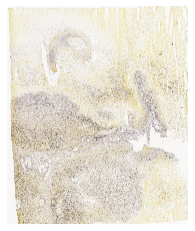

In [30]:
plt.imshow(nos2_ish_section_image_table["primary"][0].load())
plt.axis('off')

(-0.5, 15039.5, 18079.5, -0.5)

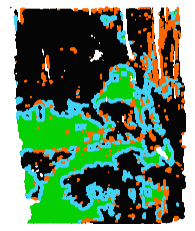

In [31]:
plt.imshow(nos2_ish_section_image_table["annotation"][0].load())
plt.axis('off')

(-0.5, 15039.5, 18079.5, -0.5)

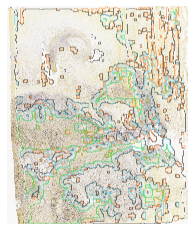

In [32]:
plt.imshow(nos2_ish_section_image_table["boundary"][0].load())
plt.axis('off')

(-0.5, 15039.5, 18079.5, -0.5)

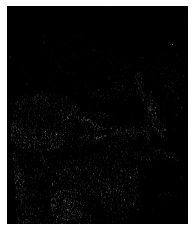

In [33]:
plt.imshow(nos2_ish_section_image_table["expression"][0].load())
plt.axis('off')

## Downloading data for local use

In many cases, needing to redownload image data for new analysis sessions will be costly in terms of bandwidth. The `open_dataset_tools` repository package provides some useful helper functions that will download images (and their S3 storage structure) to a local directory of choice:

In [34]:
from pathlib import Path
from open_dataset_tools.ivy_gap_utils import local_section_metadata_loader, section_image_downloader

In [35]:
# Change this to a location on your computer with ample space
local_save_directory = Path("/local1/IVY_GAP")

section_image_downloader(local_save_directory, 294215359, verbose=True)


Saving image from s3://allen-ivy-glioblastoma-atlas/donor_15350/specimen_293591387/primary/293591387_21_294215361.jpg to /local1/IVY_GAP/donor_15350/specimen_293591387/primary/293591387_21_294215361.jpg

Saving image from s3://allen-ivy-glioblastoma-atlas/donor_15350/specimen_293591387/annotation/293591387_21_294215361_annotation.jpg to /local1/IVY_GAP/donor_15350/specimen_293591387/annotation/293591387_21_294215361_annotation.jpg

Saving image from s3://allen-ivy-glioblastoma-atlas/donor_15350/specimen_293591387/boundary/293591387_21_294215361_boundary.jpg to /local1/IVY_GAP/donor_15350/specimen_293591387/boundary/293591387_21_294215361_boundary.jpg

Saving image from s3://allen-ivy-glioblastoma-atlas/donor_15350/specimen_293591387/expression/293591387_21_294215361_expression.jpg to /local1/IVY_GAP/donor_15350/specimen_293591387/expression/293591387_21_294215361_expression.jpg



Once downloaded to a local directory, one can use the `section_image_loader` function introduced in the previous section by providing a local save directory as a `local_save_directory` parameter like so:

In [36]:
local_section_metadata = local_section_metadata_loader(local_save_directory, verbose=True)

from_local_section_image_table = section_image_loader(
    section_meta_table=local_section_metadata,
    section_data_set_id=294215359,
    local_save_directory=local_save_directory,
    verbose=True
)

from_local_section_image_table

Loading section_metadata.json from /local1/IVY_GAP/section_metadata.json



,bits_per_component,sub_image_id,resolution,section_number,width,height,primary,annotation,boundary,expression
0,8,294215361,0.4945,21,15040,18080,<open_dataset_tools.ivy_gap_utils.ImagePromise...,<open_dataset_tools.ivy_gap_utils.ImagePromise...,<open_dataset_tools.ivy_gap_utils.ImagePromise...,<open_dataset_tools.ivy_gap_utils.ImagePromise...


Loading image from: /local1/IVY_GAP/donor_15350/specimen_293591387/primary/293591387_21_294215361.jpg


(-0.5, 15039.5, 18079.5, -0.5)

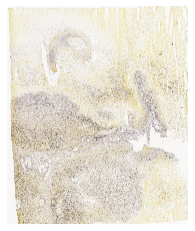

In [37]:
plt.imshow(from_local_section_image_table["primary"][0].load())
plt.axis('off')

## Downloading the entire dataset

Below is an example which downloads all the image files from the dataset. Be aware that this will take ~8.5 Terabytes!! So make sure there is ample space (and time) before attempting to run the example below.

NOTE: If space is an issue, it is entirely possible to use the filtering techniques shown throughout this example notebook to pare down the `section_metadata_table`. The new subset of `section_data_set_id` values in the pared down table can then be used with the `section_image_downloader` function. This will be left as an exercise for the reader.

In [ ]:
local_full_data_set_save_directory_with_more_than_9tb_space = Path("/local1/FULL_IVY_GAP")

local_section_metadata = local_section_metadata_loader(
    local_full_data_set_save_directory_with_more_than_9tb_space, 
    verbose=True
)

for section_data_set_id in local_section_metadata["section_data_set_id"]:
    section_image_downloader(
        local_full_data_set_save_directory_with_more_than_9tb_space,
        section_data_set_id,
        verbose=True
    )